In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 27 16:40:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   32C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from numpy import asarray, zeros
from sklearn.model_selection import train_test_split
import re
import string

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Conv1D, GlobalAveragePooling1D, Bidirectional, LSTM, Dense, Dropout, Concatenate, Dot, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import RMSprop, Adam, AdamW, Nadam
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score

In [4]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Optional: set memory growth so it doesn't allocate all memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU is set for training!")
    except RuntimeError as e:
        print(e)


✅ GPU is set for training!


In [6]:
# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
# 1. Data Loading with Language Column
encodings = ['utf-8', 'utf-8-sig', 'latin1', 'ISO-8859-1']
df = None
for encoding in encodings:
    try:
        df = pd.read_csv('/content/drive/MyDrive/things/FF.csv', encoding=encoding)
        break
    except UnicodeDecodeError:
        continue

if df is None:
    raise ValueError("Failed to load CSV file with all attempted encodings")

In [8]:
df.head()

,comment,toxic,insult,profanity,threat,identity hate,very_toxic
0,Damn wiki admins What is it with all these wik...,0,1,0,0,0,0
1,Please stop. If you continue to ignore our pol...,0,0,0,0,0,0
2,The statement about which you were bitching,0,0,0,0,0,0
3,AT Have you bookmarked ???????????????? yet? I...,0,0,0,0,0,0
4,"Hello again, Tdadamemd. Getting right to your ...",0,0,0,0,0,0


In [9]:
print(f'total number of datas: {len(df)}')

total number of datas: 46171


In [10]:
x = df.iloc[:, 1:].sum()
print(f'number comment per label taking to account the co-occurences:\n{x}')

rowsum = df.iloc[:, 1:].sum(axis=1)
print(rowsum)

no_label_count = 0
for i, count in rowsum.items():
    if count == 0:
        no_label_count += 1

print(f'total number of comments: {len(df)}')
print(f'total number of comments without label: {no_label_count}')
print(f'total number of labels: {x.sum()}')

number comment per label taking to account the co-occurences:
toxic            16166
insult           10141
profanity        10205
threat           10404
identity hate    10203
very_toxic       17053
dtype: int64
0        1
1        0
2        0
3        0
4        0
        ..
46166    2
46167    2
46168    2
46169    2
46170    2
Length: 46171, dtype: int64
total number of comments: 46171
total number of comments without label: 12518
total number of labels: 74172


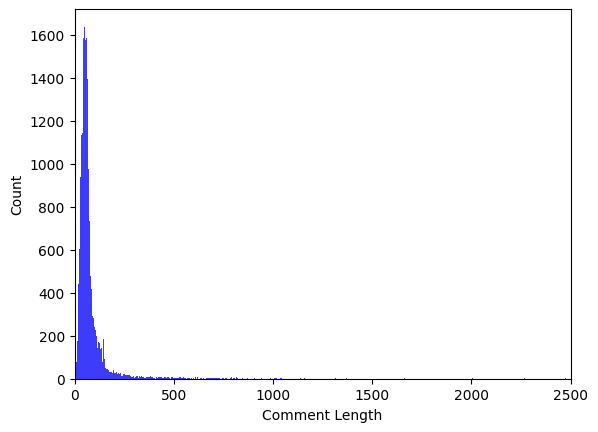

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(color_codes=True)
comment_len = df.comment.str.len()
sns.histplot(comment_len,kde=False, color="blue")
plt.xlim(0, 2500)

plt.xlabel('Comment Length')

# Display the plot
plt.show()

<Axes: >

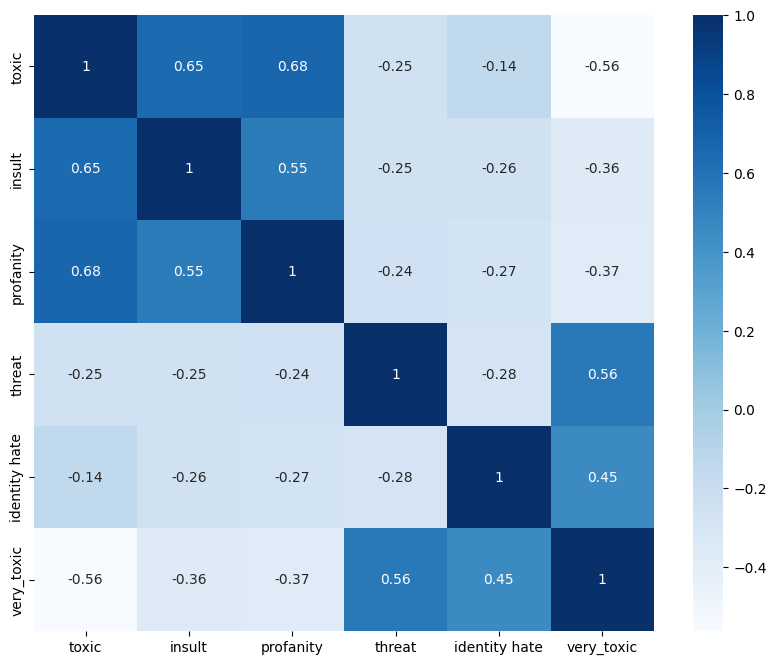

In [12]:
rowsums = df.iloc[:, 1:].sum(axis=1)
temp = df.iloc[:, 1:]
train_corr = temp[rowsums > 0]
corr = df.iloc[:, 1:].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

In [13]:
# Modify the normalize_text function
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = str(text).replace("\n", " ")
    text = re.sub(r'[^\w\s]',' ',text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('[0-9]',"",text)
    text = re.sub(" +", " ", text)
    text = re.sub("([^\x00-\x7F])+"," ",text)
    return text

In [14]:
# Split data into train, validation, and test sets (70-15-15)
X = df['comment']
y = df[df.columns[1:]].values

# Stratified split to maintain label distribution
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

In [15]:
X_train = X_train.apply(normalize_text)
X_val = X_val.apply(normalize_text)
X_test = X_test.apply(normalize_text)

In [16]:
# prompt: save in a csv file the (X_train, y_train), (X_val, y_val), (X_test, y_test)

import pandas as pd
import numpy as np

# Assuming X_train, y_train, X_val, y_val, X_test, and y_test are already defined

# Convert NumPy arrays to lists if they are not already lists
if isinstance(X_train, np.ndarray):
  X_train = X_train.tolist()
if isinstance(y_train, np.ndarray):
  y_train = y_train.tolist()
if isinstance(X_val, np.ndarray):
  X_val = X_val.tolist()
if isinstance(y_val, np.ndarray):
  y_val = y_val.tolist()
if isinstance(X_test, np.ndarray):
  X_test = X_test.tolist()
if isinstance(y_test, np.ndarray):
  y_test = y_test.tolist()

# Create dataframes
train_df = pd.DataFrame({'X_train': X_train, 'y_train': y_train})
val_df = pd.DataFrame({'X_val': X_val, 'y_val': y_val})
test_df = pd.DataFrame({'X_test': X_test, 'y_test': y_test})


# Save to CSV files
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)


In [17]:
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (32319,)
X_val shape: (6926,)
X_test shape: (6926,)


In [18]:
# print 10 comments from each labels on the X_test, y_test

def print_comments_by_label(X_test, y_test):
    """Prints 10 comments from each label in the test set."""

    labels = df.columns[1:]  # Assuming labels are in columns after 'comment'

    for i, label in enumerate(labels):
        print(f"\nComments for label: {label}")
        # Convert y_test to a NumPy array for proper slicing
        y_test_array = np.array(y_test)
        label_indices = np.where(y_test_array[:, i] == 1)[0]  # Indices where label is present

        # Ensure we print only up to 10 comments
        for j in range(min(10, len(label_indices))):
          index = label_indices[j]
          print(f"  Comment {j+1}: {X_test.iloc[index]}")

print_comments_by_label(X_test, y_test)


Comments for label: toxic
  Comment 1: i m not going to respond to queries which don t understand the material they are referring to pf haha your both stupid but at least globe doesn t take the time to write the stupid shit that wobbs has hahahahaha 
  Comment 2: pag bobo bobo na talaga as is eme ka bading kingina mo bumoboses ka pa
  Comment 3: natatawa ako pag nag titiktok to hahahaha parang si chucky
  Comment 4: mga pakshet kayong lahat patunugin niyo na ang kampanang yan
  Comment 5: man u suck lick ma ballen 
  Comment 6: its been years walang nagbago tarantado ka pa rin please lang magsawa ka na sa akin
  Comment 7: i ma smack ya upside da head wit a shovel i m takin ya down boi 
  Comment 8: what the fuck are you doing lay off my questions it s bad enough you start your own sections for your own answers a separate question is a separate question and i shouldn t have to go searching for it because you have taken it on yourself to move it 
  Comment 9: bhe medyo gago ka
  Commen


Word cloud for label: toxic


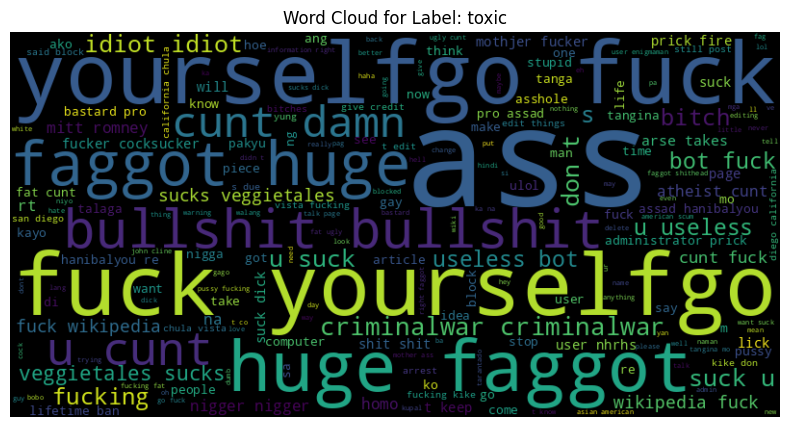


Word cloud for label: insult


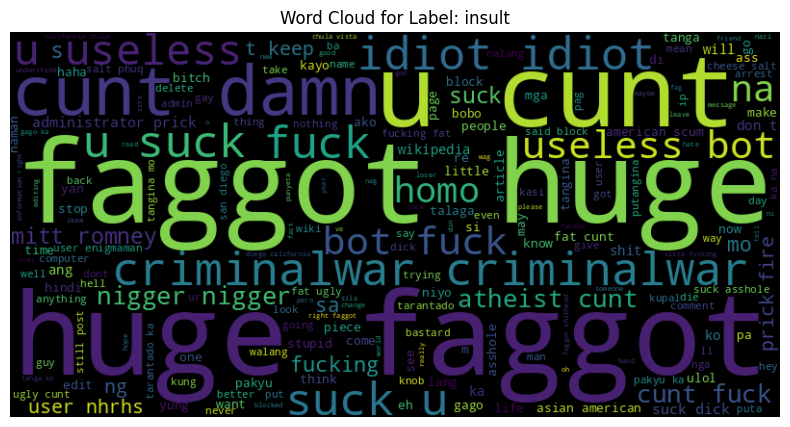


Word cloud for label: profanity


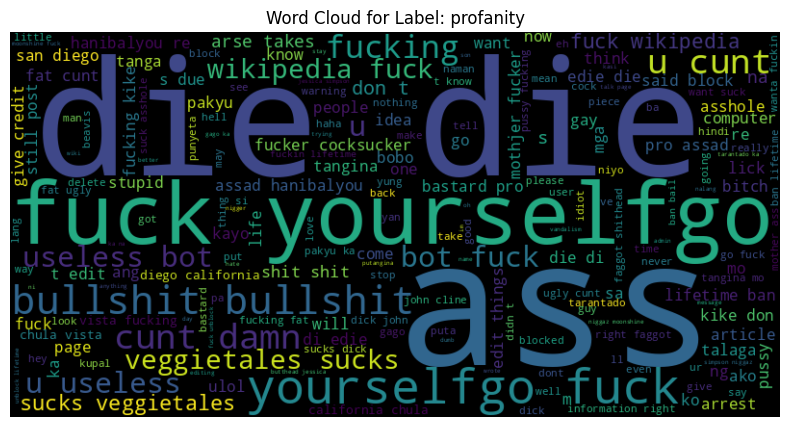


Word cloud for label: threat


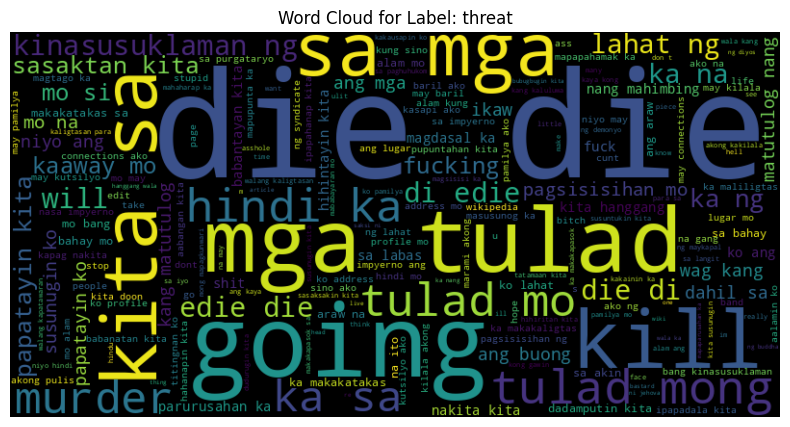


Word cloud for label: identity hate


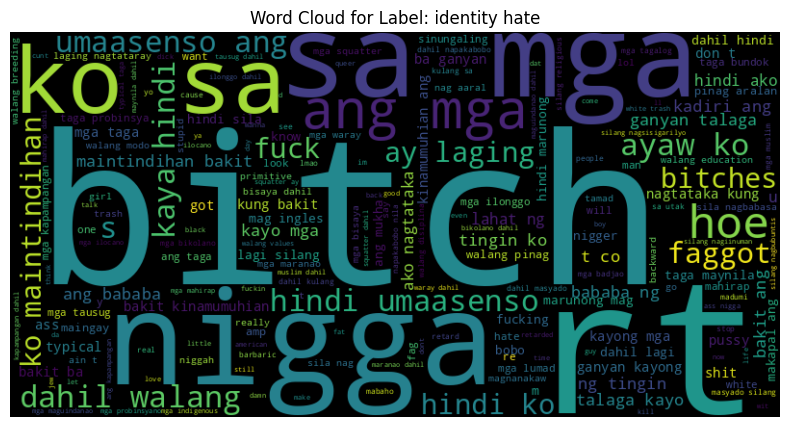


Word cloud for label: very_toxic


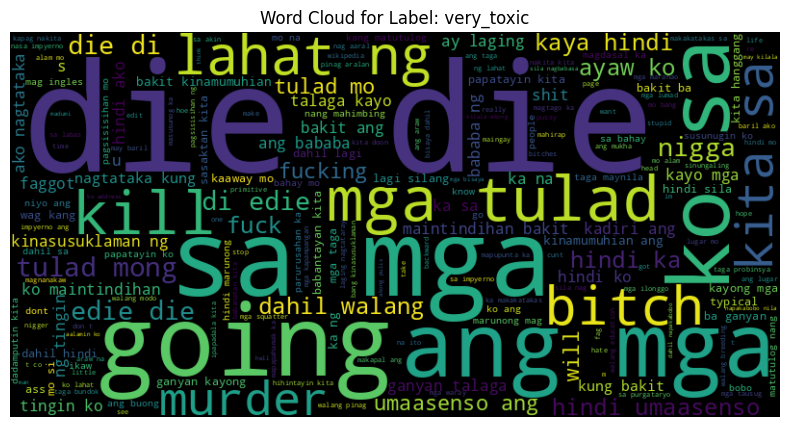

In [19]:
# make a list that will show the words for each labels use word cloud

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordclouds(X_test, y_test):
    """Generates word clouds for each label."""
    labels = df.columns[1:]

    for i, label in enumerate(labels):
        print(f"\nWord cloud for label: {label}")

        # Convert y_test to a NumPy array for proper slicing
        y_test_array = np.array(y_test)
        label_indices = np.where(y_test_array[:, i] == 1)[0]  # Indices where label is present
        label_comments = X_test.iloc[label_indices].tolist()

        # Combine comments for the current label into a single string
        text = " ".join(label_comments)

        wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Label: {label}')
        plt.show()

generate_wordclouds(X_test, y_test)

In [20]:
# Tokenization and Padding
max_features = 20000
max_len = 500

tokenizer = Tokenizer(num_words=max_features, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences and pad
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [21]:
# save the tokenizer to a json file

import json

# Assuming 'tokenizer' is already defined from the previous code
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [22]:
# Load GloVe embeddings
embed_size = 300
embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/things/glove.6B.300d.txt', 'r', encoding='utf-8')  # Update path

for line in glove_file:
    records = line.split()
    word = records[0]
    vector = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector
glove_file.close()

In [23]:
# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
num_words = min(max_features, vocab_size)
embedding_matrix = zeros((num_words, embed_size))

for word, i in tokenizer.word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
covered = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f'Coverage in embedding matrix: {covered}/{embedding_matrix.shape[0]}')

Coverage in embedding matrix: 13160/20000


In [25]:
# Create TensorFlow Datasets
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_pad, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_pad, y_test))

In [26]:
labels = ['toxic',	'insult',	'profanity',	'threat',	'identity hate',	'very_toxic']
y_train_df = pd.DataFrame(y_train, columns=labels)

for col in labels:
  print(y_train_df[col].value_counts())
  print('\n')

toxic
0    20986
1    11333
Name: count, dtype: int64


insult
0    25192
1     7127
Name: count, dtype: int64


profanity
0    25155
1     7164
Name: count, dtype: int64


threat
0    24982
1     7337
Name: count, dtype: int64


identity hate
0    25199
1     7120
Name: count, dtype: int64


very_toxic
0    20340
1    11979
Name: count, dtype: int64




In [27]:
labels = ['toxic',	'insult',	'profanity',	'threat',	'identity hate',	'very_toxic']
y_val_df = pd.DataFrame(y_val, columns=labels)

for col in labels:
  print(y_val_df[col].value_counts())
  print('\n')

toxic
0    4482
1    2444
Name: count, dtype: int64


insult
0    5385
1    1541
Name: count, dtype: int64


profanity
0    5391
1    1535
Name: count, dtype: int64


threat
0    5399
1    1527
Name: count, dtype: int64


identity hate
0    5392
1    1534
Name: count, dtype: int64


very_toxic
0    4389
1    2537
Name: count, dtype: int64




In [28]:
labels = ['toxic',	'insult',	'profanity',	'threat',	'identity hate',	'very_toxic']
y_test_df = pd.DataFrame(y_test, columns=labels)

for col in labels:
  print(y_test_df[col].value_counts())
  print('\n')

toxic
0    4537
1    2389
Name: count, dtype: int64


insult
0    5453
1    1473
Name: count, dtype: int64


profanity
0    5420
1    1506
Name: count, dtype: int64


threat
0    5386
1    1540
Name: count, dtype: int64


identity hate
0    5377
1    1549
Name: count, dtype: int64


very_toxic
0    4389
1    2537
Name: count, dtype: int64




In [29]:
# Shuffle and batch
train_dataset = train_dataset.cache().shuffle(16000).batch(batch_size).prefetch(8)
val_dataset = val_dataset.cache().batch(batch_size).prefetch(8)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(8)

In [30]:
sequence_input = Input(shape=(max_len,))

x = Embedding(input_dim=num_words,output_dim=embed_size,weights=[embedding_matrix],trainable=False)(sequence_input)
x = SpatialDropout1D(0.2)(x)

x = Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)

avg_pool = GlobalAveragePooling1D()(x)

x = Dense(128, activation='relu', kernel_initializer='he_uniform')(avg_pool)
x = Dropout(0.1)(x)

preds = Dense(6, activation="sigmoid", kernel_initializer="glorot_uniform")(x)

model = Model(sequence_input, preds)

In [31]:
#model.layers[1].trainable = False

model.compile(loss='binary_crossentropy',optimizer=Nadam(learning_rate=1e-3),metrics=[
            tf.keras.metrics.Precision(name='prec'),
             tf.keras.metrics.Recall(name='rec'),
             tf.keras.metrics.AUC(name='auc')])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 500, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 500, 300)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 498, 64)        │        57,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 498, 256)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,288,966 (23.99 MB)

 Trainable params: 288,966 (1.10 MB)

 Non-trainable params: 6,000,000 (22.89 MB)

In [32]:
checkpoint_path = "best_model_Nadam.keras"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,   # save full model
    monitor='val_loss',        # metric to track
    save_best_only=True,       # only save when it improves
    mode='min'                 # val_loss: lower is better
)


In [33]:
# Train with embedding frozen
history_frozen = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,      # just a few epochs
    callbacks=[cp_callback],
    verbose=1
)

Epoch 1/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - auc: 0.6165 - loss: 0.5729 - prec: 0.5650 - rec: 0.0876 - val_auc: 0.7231 - val_loss: 0.5136 - val_prec: 0.7739 - val_rec: 0.1731
Epoch 2/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - auc: 0.7459 - loss: 0.4994 - prec: 0.7374 - rec: 0.2507 - val_auc: 0.8726 - val_loss: 0.3805 - val_prec: 0.7199 - val_rec: 0.5140
Epoch 3/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - auc: 0.8749 - loss: 0.3821 - prec: 0.7350 - rec: 0.5282 - val_auc: 0.8996 - val_loss: 0.3502 - val_prec: 0.7290 - val_rec: 0.6422
Epoch 4/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - auc: 0.9071 - loss: 0.3371 - prec: 0.7506 - rec: 0.6489 - val_auc: 0.9398 - val_loss: 0.2733 - val_prec: 0.7802 - val_rec: 0.7516
Epoch 5/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 550s 2s/step - auc: 0.9336 - loss: 0.2860 - prec: 0.7760 - rec: 0.7323 - val_auc: 0.9487 - val_loss: 0.2525 - val_prec: 0.7933 - val_rec: 0.7766


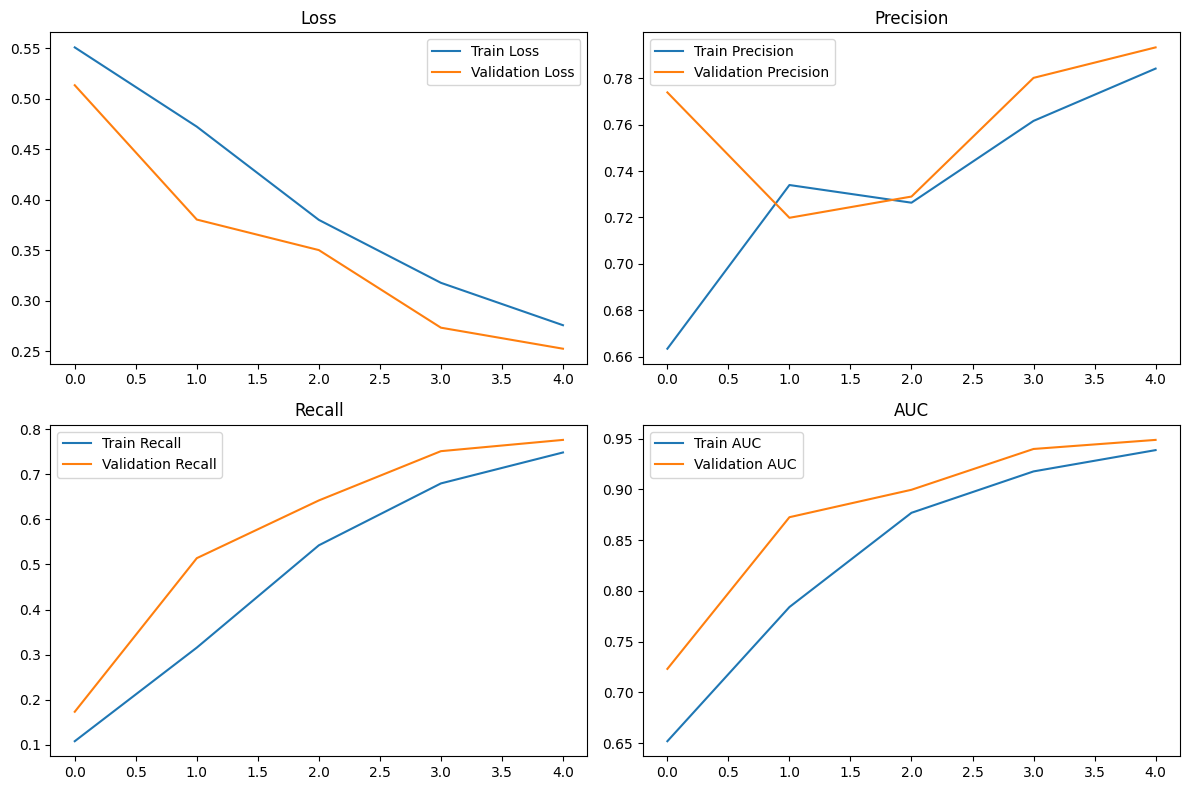

In [34]:
# prompt: plot the precision, recall, loss, auc for the train and val

# Plot training history
plt.figure(figsize=(12, 8))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(history_frozen.history['loss'], label='Train Loss')
plt.plot(history_frozen.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(history_frozen.history['prec'], label='Train Precision')
plt.plot(history_frozen.history['val_prec'], label='Validation Precision')
plt.legend()
plt.title('Precision')

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(history_frozen.history['rec'], label='Train Recall')
plt.plot(history_frozen.history['val_rec'], label='Validation Recall')
plt.legend()
plt.title('Recall')

# Plot AUC
plt.subplot(2, 2, 4)
plt.plot(history_frozen.history['auc'], label='Train AUC')
plt.plot(history_frozen.history['val_auc'], label='Validation AUC')
plt.legend()
plt.title('AUC')

plt.tight_layout()
plt.show()


In [35]:
import numpy as np
from sklearn.metrics import f1_score

# Get predictions and true labels
y_probs = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Find optimal threshold for each label
best_thresholds = []
for i in range(y_true.shape[1]):
    f1s = []
    thresholds = np.linspace(0.0, 1.0, 101)  # Covers 0.00 to 1.00 in 0.01 steps
    for t in thresholds:
        y_pred_label = (y_probs[:, i] > t).astype(int)
        f1 = f1_score(y_true[:, i], y_pred_label, zero_division=0)  # Handle division warnings
        f1s.append(f1)

    best_idx = np.argmax(f1s)
    best_t = thresholds[best_idx]
    best_f1 = f1s[best_idx]

    best_thresholds.append(best_t)
    print(f"Label {i}: Best Threshold = {best_t:.4f}, F1-Score = {best_f1:.4f}")

best_thresholds = np.array(best_thresholds)

55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 386ms/step
Label 0: Best Threshold = 0.3400, F1-Score = 0.7832
Label 1: Best Threshold = 0.3300, F1-Score = 0.7470
Label 2: Best Threshold = 0.3600, F1-Score = 0.7587
Label 3: Best Threshold = 0.6500, F1-Score = 0.8558
Label 4: Best Threshold = 0.3900, F1-Score = 0.8822
Label 5: Best Threshold = 0.4000, F1-Score = 0.8157


In [36]:
y_pred = (y_probs > best_thresholds).astype(int)

In [37]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=df.columns[1:]))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

        toxic       0.72      0.86      0.78      2389
       insult       0.68      0.82      0.75      1473
    profanity       0.69      0.84      0.76      1506
       threat       0.93      0.79      0.86      1540
identity hate       0.92      0.85      0.88      1549
   very_toxic       0.75      0.89      0.82      2537

    micro avg       0.76      0.85      0.80     10994
    macro avg       0.78      0.84      0.81     10994
 weighted avg       0.78      0.85      0.81     10994
  samples avg       0.57      0.61      0.58     10994

ROC AUC Score: 0.8719669015377046


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


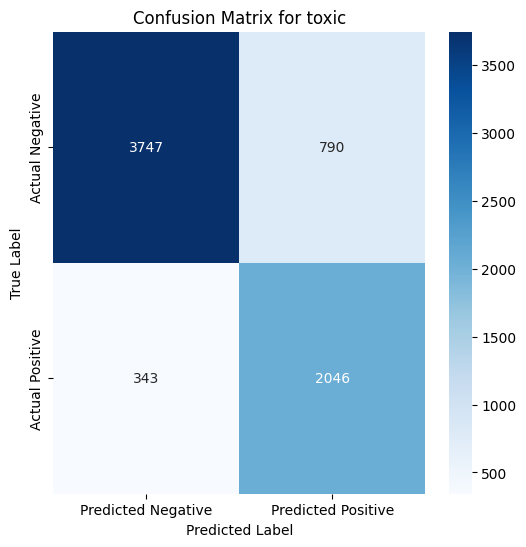

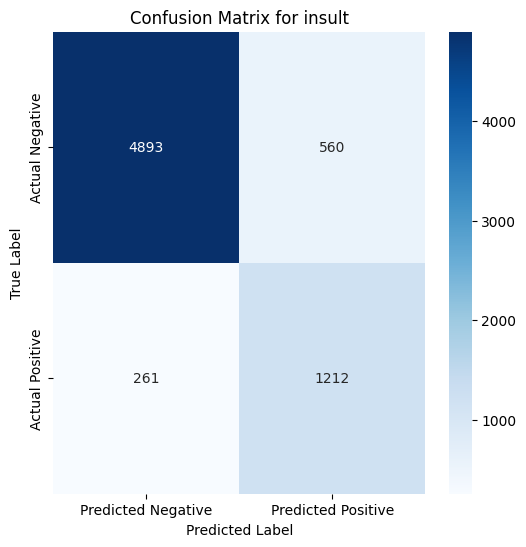

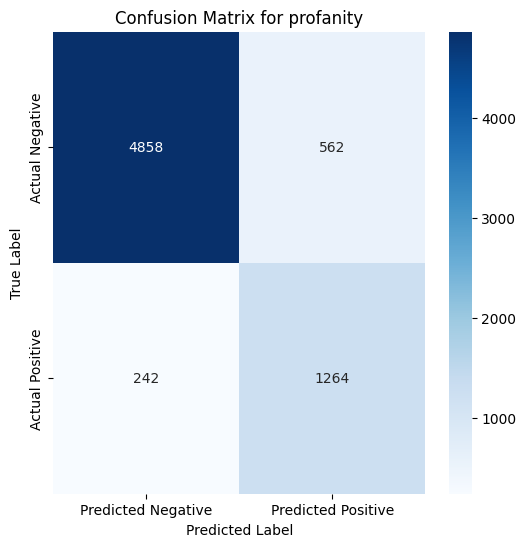

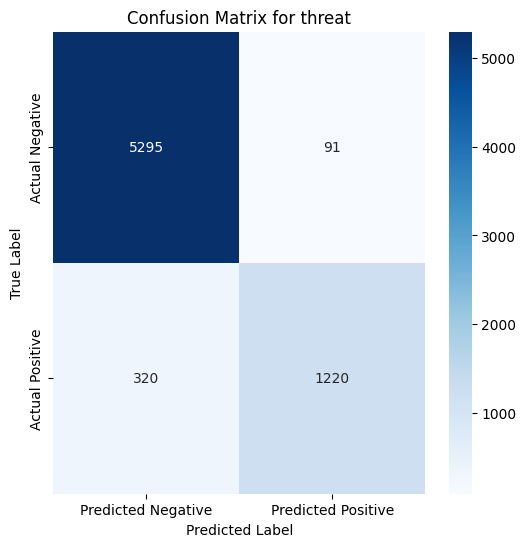

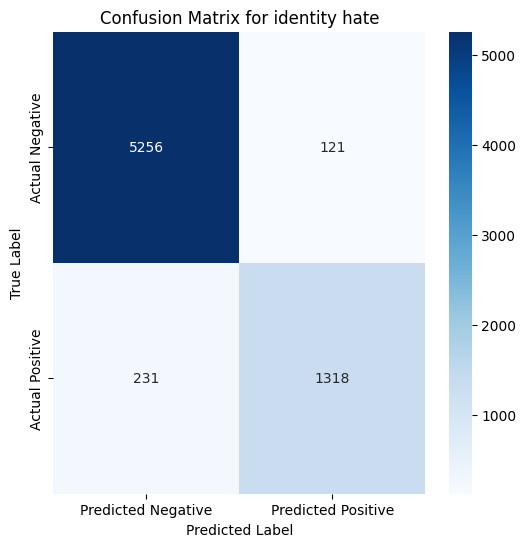

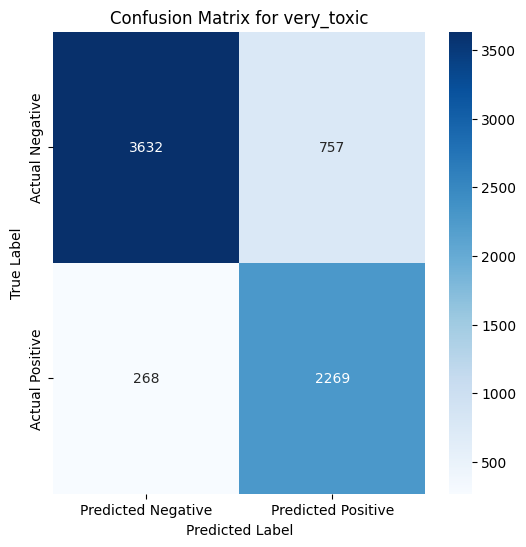

In [38]:
# prompt: i want to print the confusion matrix of each labels

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate and plot confusion matrices for each label
for i, label in enumerate(df.columns[1:]):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [39]:
#model.save('ten_epoch_Nadam.keras')

continue training

In [42]:
# Re‑load the best model from the checkpoint
best_model = tf.keras.models.load_model("best_model_Nadam.keras")

In [43]:
# Continue training for epochs 5→10
history2 = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,               # final epoch number
    initial_epoch=5,         # start from where you left off
    callbacks=[cp_callback], # keep saving further improvements
    verbose=1
)

Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - auc: 0.9466 - loss: 0.2576 - prec: 0.7988 - rec: 0.7735 - val_auc: 0.9541 - val_loss: 0.2387 - val_prec: 0.8048 - val_rec: 0.7946
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - auc: 0.9531 - loss: 0.2421 - prec: 0.8112 - rec: 0.7943 - val_auc: 0.9576 - val_loss: 0.2294 - val_prec: 0.8147 - val_rec: 0.8034
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - auc: 0.9575 - loss: 0.2302 - prec: 0.8191 - rec: 0.8041 - val_auc: 0.9609 - val_loss: 0.2216 - val_prec: 0.8167 - val_rec: 0.8219
Epoch 9/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 550s 2s/step - auc: 0.9604 - loss: 0.2226 - prec: 0.8256 - rec: 0.8132 - val_auc: 0.9619 - val_loss: 0.2183 - val_prec: 0.8247 - val_rec: 0.8305
Epoch 10/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - auc: 0.9628 - loss: 0.2158 - prec: 0.8324 - rec: 0.8220 - val_auc: 0.9629 - val_loss: 0.2150 - val_prec: 0.8290 - val_rec: 0.8237


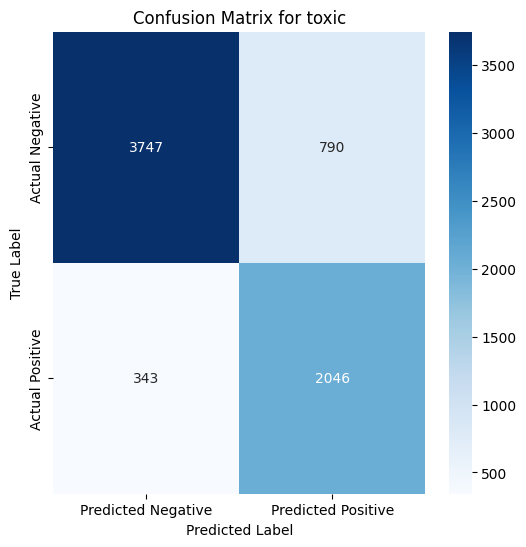

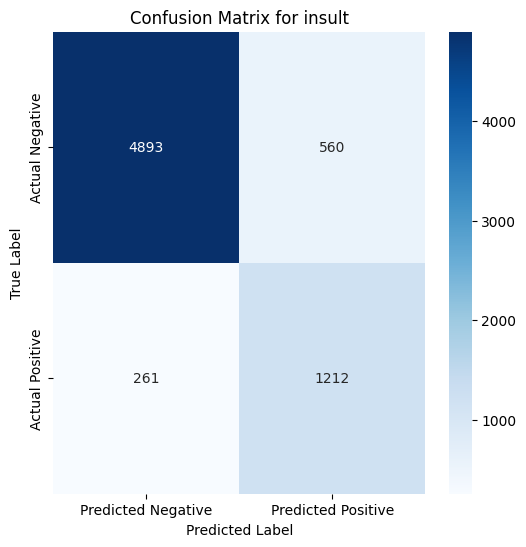

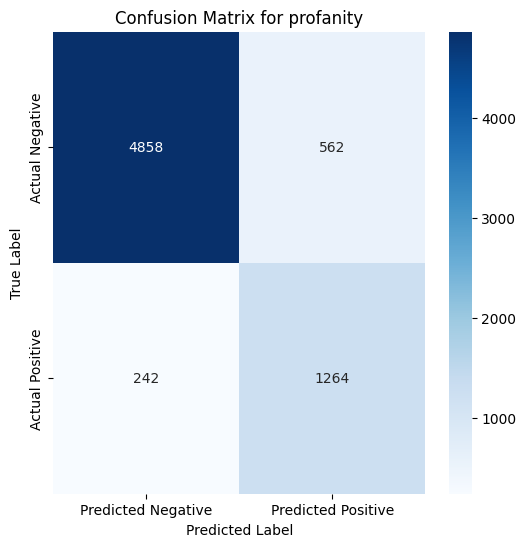

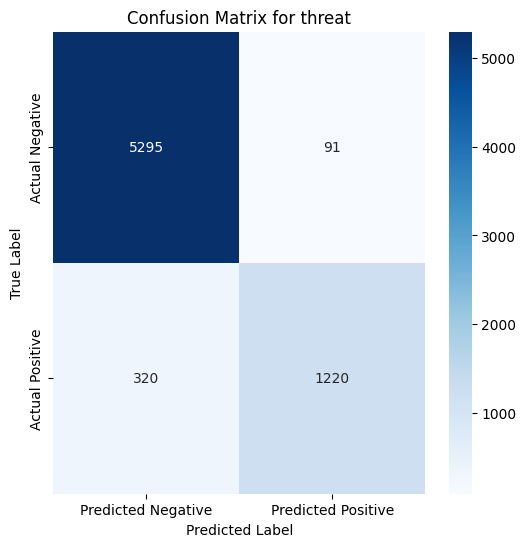

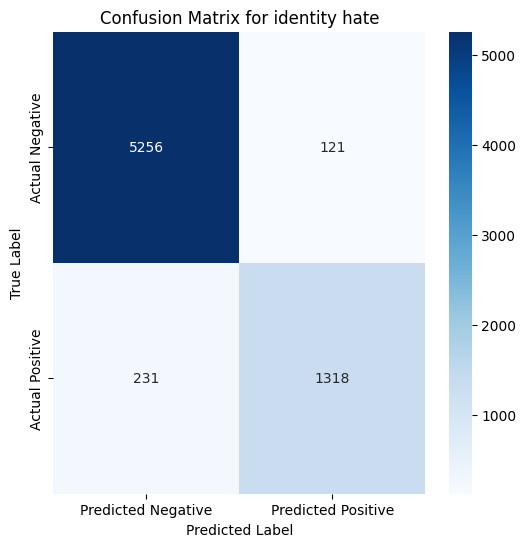

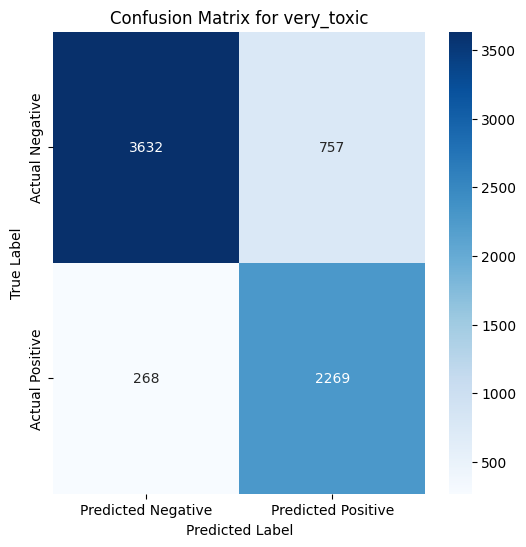

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate and plot confusion matrices for each label
for i, label in enumerate(df.columns[1:]):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [45]:
from sklearn.metrics import precision_recall_curve

for i in range(y_true.shape[1]):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_probs[:, i])
    f1s = 2 * (precision * recall) / (precision + recall + 1e-8)  # Avoid division by 0
    best_idx = np.argmax(f1s)
    best_t = thresholds[best_idx]
    print(f"Label {i}: Best Threshold = {best_t:.4f}")


Label 0: Best Threshold = 0.3211
Label 1: Best Threshold = 0.3085
Label 2: Best Threshold = 0.3529
Label 3: Best Threshold = 0.6494
Label 4: Best Threshold = 0.3850
Label 5: Best Threshold = 0.3968


In [46]:
y_pred = (y_probs > best_thresholds).astype(int)

In [47]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=df.columns[1:]))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

        toxic       0.72      0.86      0.78      2389
       insult       0.68      0.82      0.75      1473
    profanity       0.69      0.84      0.76      1506
       threat       0.93      0.79      0.86      1540
identity hate       0.92      0.85      0.88      1549
   very_toxic       0.75      0.89      0.82      2537

    micro avg       0.76      0.85      0.80     10994
    macro avg       0.78      0.84      0.81     10994
 weighted avg       0.78      0.85      0.81     10994
  samples avg       0.57      0.61      0.58     10994

ROC AUC Score: 0.8719669015377046


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


getting the threshold on balance precision and recall

In [48]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Get predictions and true labels
y_probs = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Find the threshold where precision and recall are balanced
best_thresholds = []
for i in range(y_true.shape[1]):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_probs[:, i])

    # Find the threshold where precision and recall are closest
    diff = np.abs(precision - recall)  # Compute the absolute difference
    best_idx = np.argmin(diff)  # Find index where difference is minimal
    best_t = thresholds[best_idx]

    print(f"Label {i}: Best Threshold (Precision = Recall) = {best_t:.4f}, Precision = {precision[best_idx]:.4f}, Recall = {recall[best_idx]:.4f}")

    best_thresholds.append(best_t)

best_thresholds = np.array(best_thresholds)


55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step
Label 0: Best Threshold (Precision = Recall) = 0.4655, Precision = 0.7694, Recall = 0.7694
Label 1: Best Threshold (Precision = Recall) = 0.4460, Precision = 0.7305, Recall = 0.7305
Label 2: Best Threshold (Precision = Recall) = 0.5099, Precision = 0.7264, Recall = 0.7264
Label 3: Best Threshold (Precision = Recall) = 0.4550, Precision = 0.8506, Recall = 0.8506
Label 4: Best Threshold (Precision = Recall) = 0.2839, Precision = 0.8799, Recall = 0.8799
Label 5: Best Threshold (Precision = Recall) = 0.5513, Precision = 0.8096, Recall = 0.8096


continue training from 10 ->15

In [ ]:
#best_model.save('final_model_15_epoch.keras')

INFERENCING

In [39]:
def preprocess_texts(texts, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded

In [49]:
# Example label names
label_names = ['toxic',	'insult',	'profanity',	'threat',	'identity hate',	'very_toxic']

# Example: you should replace this with the actual thresholds you computed
best_thresholds = np.array([0.4655, 0.4460, 0.5099, 0.4550, 0.2839, 0.5513])
#0.34, 0.33, 0.36, 0.65, 0.39, 0.40
def predict_texts(texts, model, tokenizer, max_len, thresholds, labels):
    X_input = preprocess_texts(texts, tokenizer, max_len)
    probs = model.predict(X_input)
    preds = (probs > thresholds).astype(int)

    for i, text in enumerate(texts):
        print(f"\n📝 Text: {text}")
        pred_labels = [labels[j] for j in range(len(labels)) if preds[i][j] == 1]
        print(f"🚩 Predicted Labels: {pred_labels if pred_labels else ['Not Toxic']}")


In [56]:
predict_texts(
    ["You are the worst!", "Srsly Slayed anime. Ang petmalu! #PinoyPride","why do i care?", "bakla kang tangina ka",
     "ewan ko sayo mukha kang nigga","goodmorning everyone!!","I think viral challenges is so fresh! Slay naman ang barkada.",
     "sana mamatay ka na bitch!!", "fuck this shit im done","papatyin kita!","i will kill you",
     "Ganyan talaga kayo mga lumad. walang pinag-aralan."],
    model,
    tokenizer,
    max_len,
    best_thresholds,
    label_names
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step

📝 Text: You are the worst!
🚩 Predicted Labels: ['threat', 'very_toxic']

📝 Text: Srsly Slayed anime. Ang petmalu! #PinoyPride
🚩 Predicted Labels: ['Not Toxic']

📝 Text: why do i care?
🚩 Predicted Labels: ['threat', 'very_toxic']

📝 Text: bakla kang tangina ka
🚩 Predicted Labels: ['toxic', 'insult', 'profanity']

📝 Text: ewan ko sayo mukha kang nigga
🚩 Predicted Labels: ['toxic', 'insult', 'profanity']

📝 Text: goodmorning everyone!!
🚩 Predicted Labels: ['Not Toxic']

📝 Text: I think viral challenges is so fresh! Slay naman ang barkada.
🚩 Predicted Labels: ['Not Toxic']

📝 Text: sana mamatay ka na bitch!!
🚩 Predicted Labels: ['toxic', 'insult', 'profanity']

📝 Text: fuck this shit im done
🚩 Predicted Labels: ['toxic', 'profanity']

📝 Text: papatyin kita!
🚩 Predicted Labels: ['threat', 'very_toxic']

📝 Text: i will kill you
🚩 Predicted Labels: ['threat', 'very_toxic']

📝 Text: Ganyan talaga kayo mga lumad. walang pinag-aralan.
🚩 Predicted Labels: [

In [ ]:
#no_5 = load_model('best_model.keras')

In [ ]:
"""new_tresh = np.array([0.39, 0.25, 0.21, 0.53, 0.46, 0.49])
predict_texts(
    ["You are the worst!", "nakita mo yung assignement kanina?","why do i care bakla kang tangina ka",
     "ewan ko sayo mukha kang nigga","goodmorning everyone!!","eto ay isang sample comment",
     "sana mamatay ka na bitch!!", "fuck this shit im done","papatyin kita!"],
    no_5,
    tokenizer,
    max_len,
    best_thresholds,
    label_names
)"""